In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys

import util_tr_new as tr
from scipy import interpolate  # , signal
from scipy.signal import savgol_filter

datadir = Path("/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231127_#1-1379(1-1)")
sample = "1379"
if not os.path.exists(datadir / sample):
    os.mkdir(datadir / sample)
savedir = datadir / sample

thickness = 2e-8  # m = 20 nm
width = 2e-5  # m = 20 um
e = 1.602e-19  # C

B_Rxx2omega, thresh_Rxx2omega = 2.5, 0.01
B_gamma, thresh_gamma = 0.1, 0.01 # 0.2がいい説もある

current=  5e-05


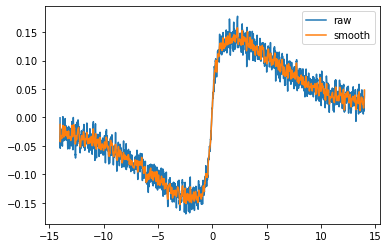

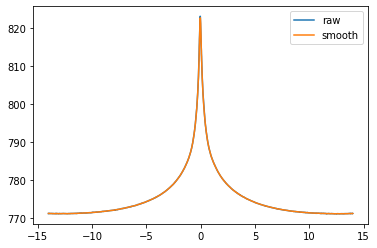

R0 =  822.6951845293408 , B =  -0.022621600000000002
gamma =  6.274229683889817e-12


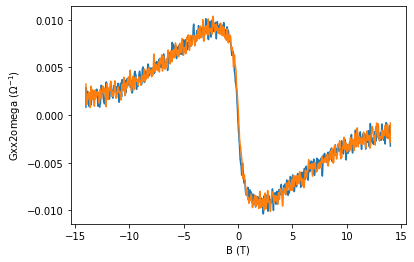

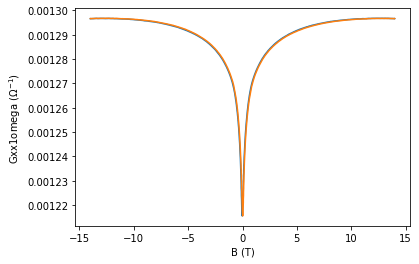

3_14T_sweep_5e-5A.csv saved


In [2]:
df_dict = {}
# for filename in sorted(glob(str(datadir / "3_14T_sweep_*e-*A.txt"))):
filename = str(datadir / "3_14T_sweep_5e-5A.txt")
key = Path(filename).stem

with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)
# df_dict[Path(filename).stem] = df
df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
fixed_temp = df["Temperature (K)"].mean()
Vxx2omega_raw = df["Lock-in2(Y)"].values
Vxx1omega_raw = -df["Lock-in1(X)"].values
B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx2omega_raw))
B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx1omega_raw))
# (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

# V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
# V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
temp = np.full_like(B_ref_u, fixed_temp)

current_float = float(key[-5:-1])
print("current= ", current_float)
Rxx2omega_u = Vxx2omega_u / current_float
Rxx2omega_d = Vxx2omega_d / current_float
Rxx1omega_u = Vxx1omega_u / current_float
Rxx1omega_d = Vxx1omega_d / current_float
Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
plt.plot(B_ref_d, Rxx2omega_d, label="raw")
plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
plt.legend()
plt.show()
plt.plot(B_ref_d, Rxx1omega_u, label="raw")
plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
plt.legend()
plt.show()
current = np.full_like(B_ref_u, current_float)
idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]

current_density = current_float / (width * thickness)  # A/m^2

# Rxx1omegaの最大値をR0とする
R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

gamma = 2 * (DeltaR / DeltaB) / (current_density * R0)

print("gamma = ", gamma)

Gxx1omega_d = savgol_filter(current_float / Vxx1omega_d,  21, 3)
Gxx1omega_u = savgol_filter(current_float / Vxx1omega_u,  21, 3)
Gxx2omega_d = savgol_filter(-2*Vxx2omega_d / (Vxx1omega_d)**2,  21, 3)
Gxx2omega_u = savgol_filter(-2*Vxx2omega_u / (Vxx1omega_u)**2,  21, 3)
plt.plot(B_ref_d, Gxx2omega_d)
plt.plot(B_ref_u, Gxx2omega_u)
plt.xlabel("B (T)")
plt.ylabel(r"Gxx2omega ($\Omega^{-1}$)")
plt.show()
plt.plot(B_ref_d, Gxx1omega_d)
plt.plot(B_ref_u, Gxx1omega_u)
plt.xlabel("B (T)")
plt.ylabel(r"Gxx1omega ($\Omega^{-1}$)")
plt.show()

Rxx2omega_d_over_R0_B = 2*Rxx2omega_d_smooth / (R0 * current_density)
Rxx2omega_u_over_R0_B = 2*Rxx2omega_u_smooth / (R0 * current_density)
new_df = pd.DataFrame({
    "temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, 
    "Vxx2omega_u": Vxx2omega_u, "Vxx2omega_d": Vxx2omega_d, "Vxx1omega_d": Vxx1omega_d, "Vxx1omega_u": Vxx1omega_u, 
    "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, 
    "Gxx2omega_u": Gxx2omega_u, "Gxx2omega_d": Gxx2omega_d, "Gxx1omega_u": Gxx1omega_u, "Gxx1omega_d": Gxx1omega_d,
    "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B
})
new_df.to_csv(savedir / (key + ".csv"), index=False)
print(key + ".csv saved")

# current dep

3_3T_sweep_1e-3A
3_3T_sweep_1e-4A
3_3T_sweep_1e-5A
3_3T_sweep_1e-6A
3_3T_sweep_1e-7A
3_3T_sweep_2e-4A
3_3T_sweep_2e-5A
3_3T_sweep_2e-6A
3_3T_sweep_2e-7A
3_3T_sweep_5e-4A
3_3T_sweep_5e-5A
3_3T_sweep_5e-6A
3_3T_sweep_5e-7A


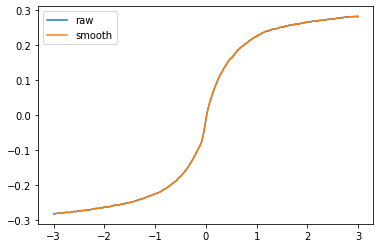

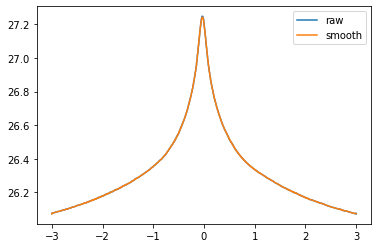

70 2.50943
R0 =  27.242201544152785 , B =  -0.029632799999999997
gamma =  9.443529505219389e-12


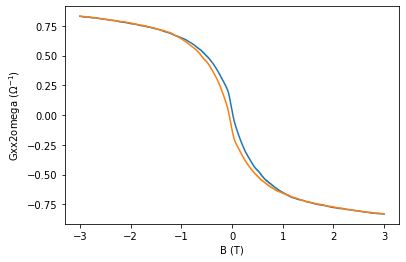

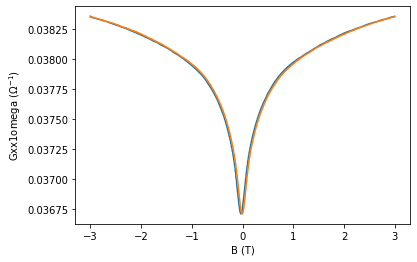

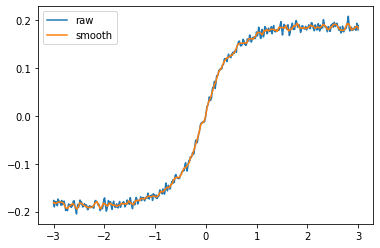

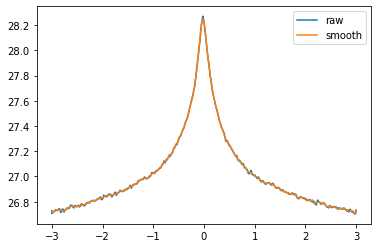

69 2.4991000000000003
R0 =  28.24598205793245 , B =  -0.0220111
gamma =  4.179393350466497e-11


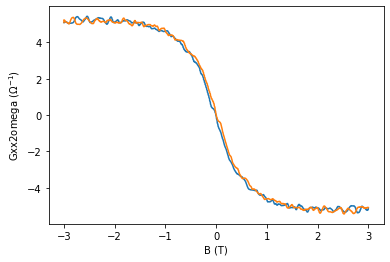

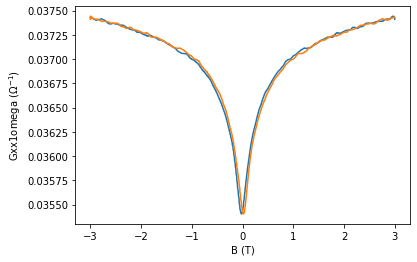

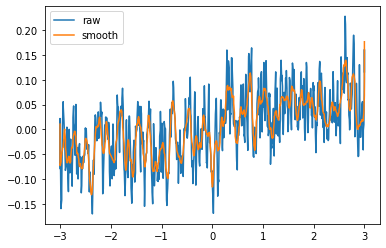

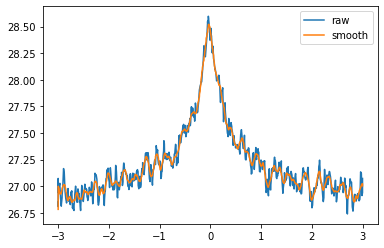

71 2.50006
R0 =  28.521589375016614 , B =  -0.0257017
gamma =  -2.0966002072983333e-10


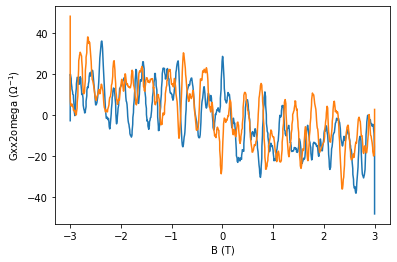

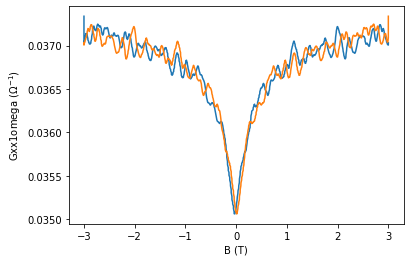

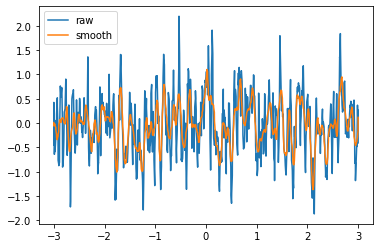

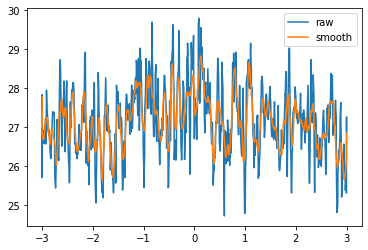

71 2.50374
R0 =  28.83132970310565 , B =  0.12073800000000001
gamma =  2.389757434559032e-08


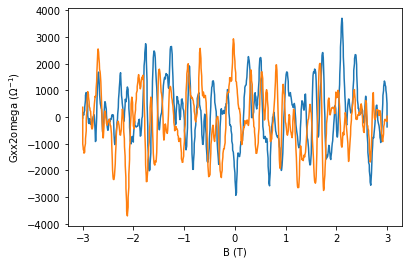

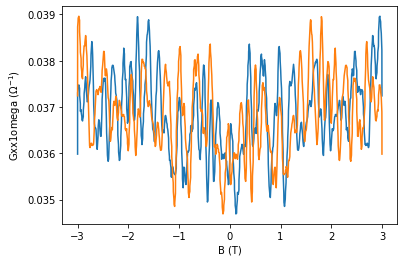

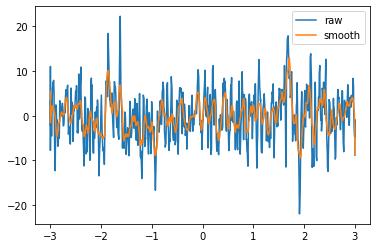

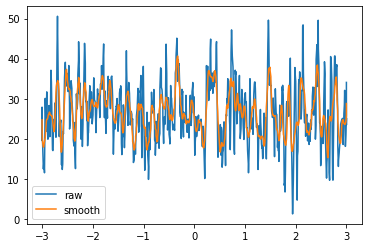

68 2.5087099999999998
R0 =  40.64133487196699 , B =  -0.32736
gamma =  -2.680563845748764e-06


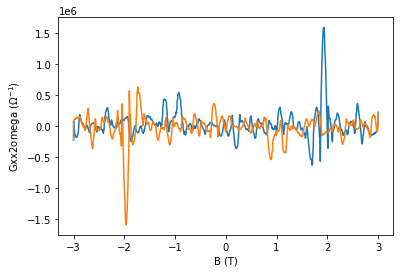

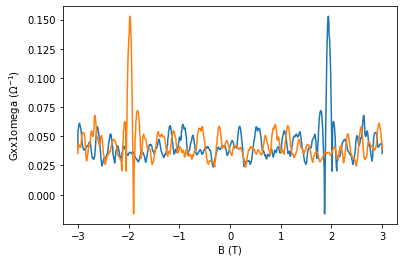

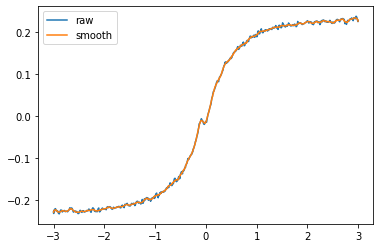

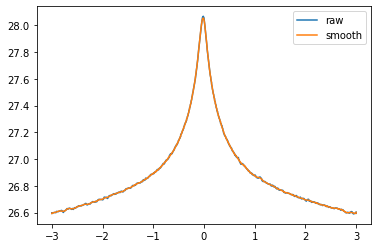

71 2.50571
R0 =  28.05508695155899 , B =  -0.0147136
gamma =  1.6304995328804748e-11


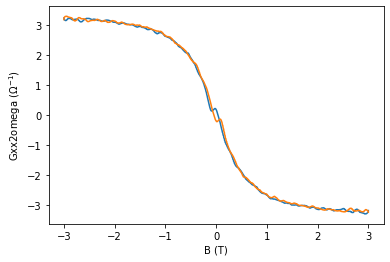

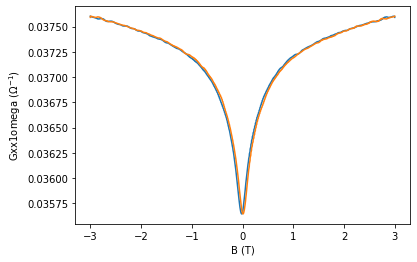

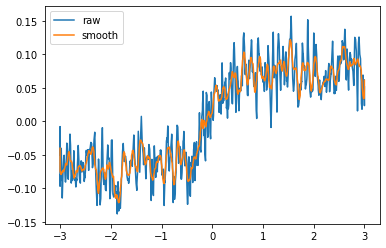

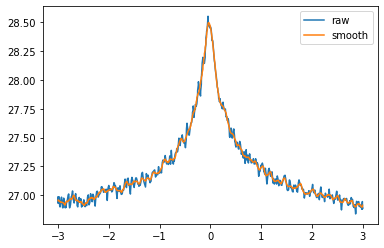

68 2.50991
R0 =  28.496745061482862 , B =  -0.0317203
gamma =  1.1731105770582406e-10


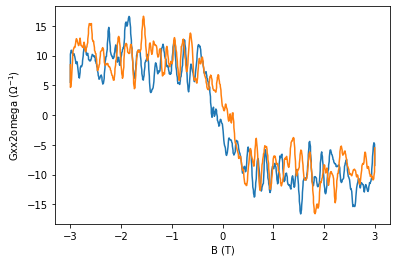

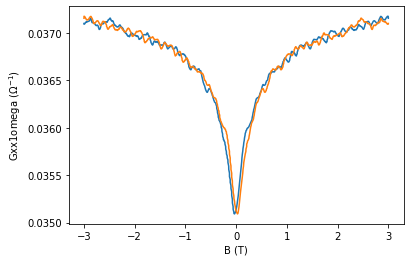

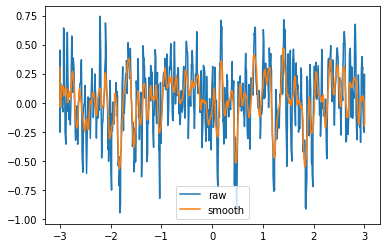

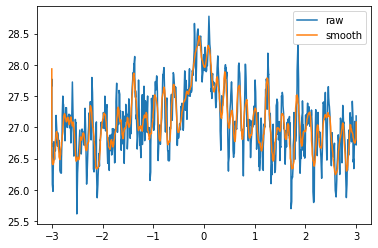

69 2.5007099999999998
R0 =  28.46196891160787 , B =  -0.09585940000000001
gamma =  -5.749086038733745e-09


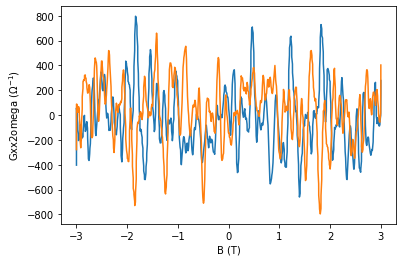

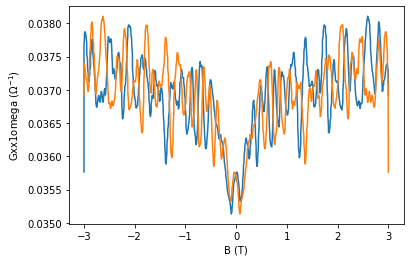

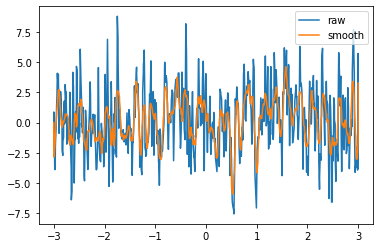

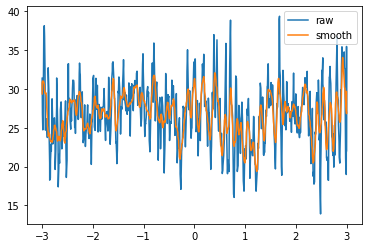

73 2.50488
R0 =  34.04837241902591 , B =  2.9237
gamma =  -6.489637091175213e-07


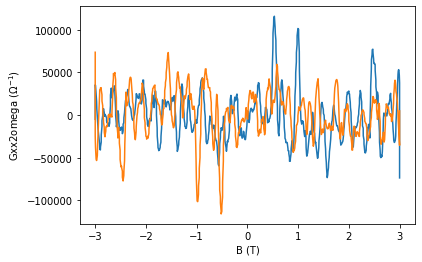

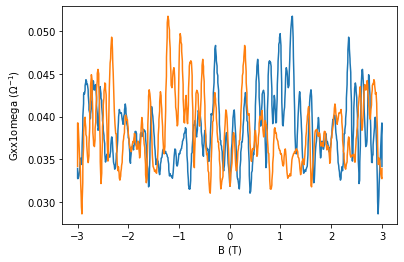

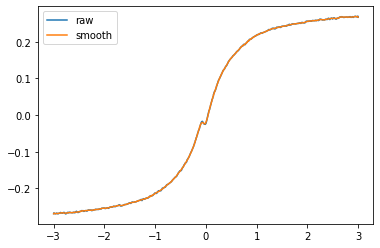

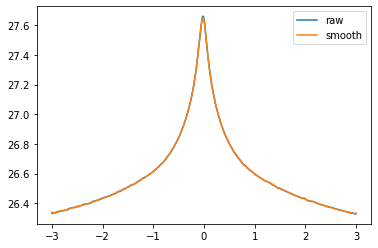

69 2.50988
R0 =  27.651093412361266 , B =  -0.0188094
gamma =  8.302777126596232e-12


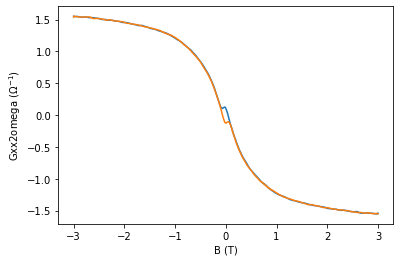

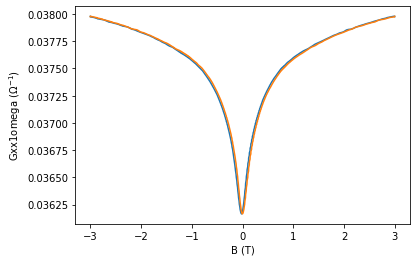

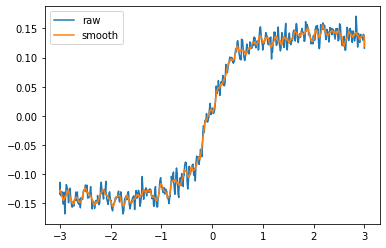

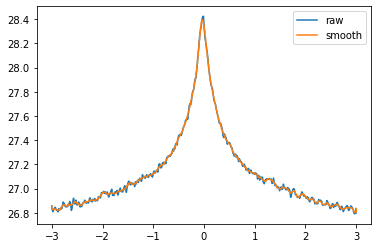

71 2.49786
R0 =  28.39381742875348 , B =  -0.0274859
gamma =  6.748529443904449e-11


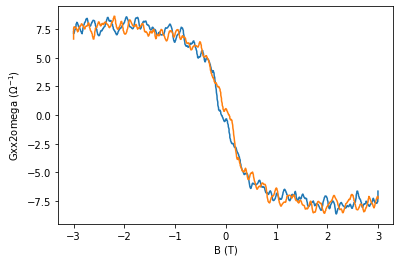

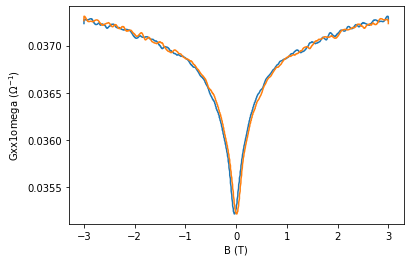

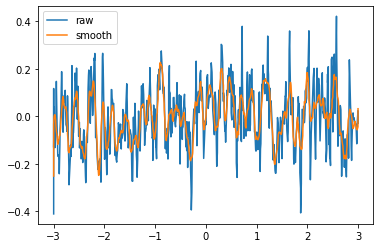

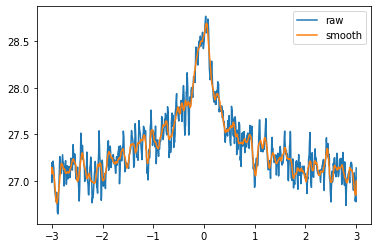

69 2.50374
R0 =  28.695220197278026 , B =  0.050878400000000004
gamma =  -2.7026970039801775e-10


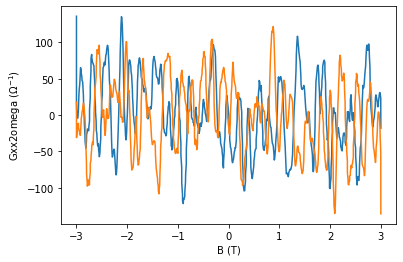

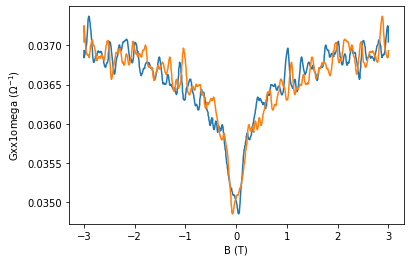

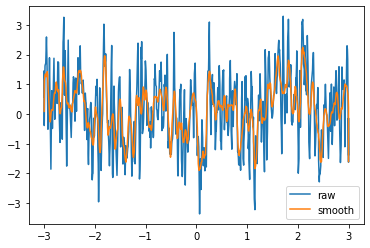

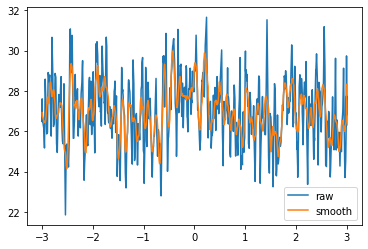

74 2.50983
R0 =  29.983391985552515 , B =  -0.427041
gamma =  -2.5024607661270087e-07


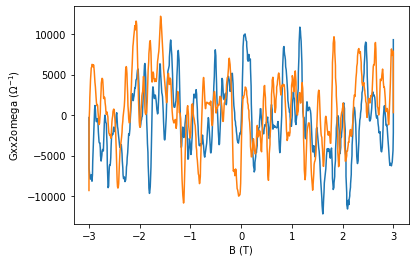

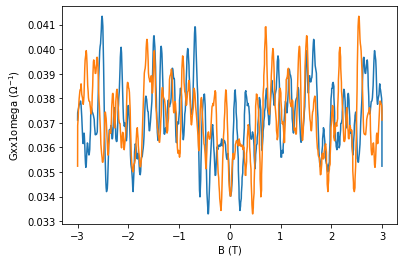

13 13 13 13
Rxx_2.5T_2K_I_dep.csv saved
[2.299995860566449, 2.2999972855591744, 2.3000004872646738, 2.3000052106430156, 2.2999960444444443, 2.299997297895903, 2.3000005094130676, 2.299999844789357, 2.3000079023307443, 2.299997726775956, 2.300000445930881, 2.3000034, 2.300000242825607]


In [4]:


df_gamma_name = f"gamma_{B_gamma}T_2K_20um_I_dep.csv"
summary_name = f"Rxx_{B_Rxx2omega}T_2K_20um_I_dep.csv"


df_dict = {}
for filename in sorted(glob(str(datadir / "3_3T_sweep_*e-*A.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    Vxx2omega_raw = df["Lock-in2(Y)"].values
    Vxx1omega_raw = df["Lock-in1(Y)"].values
    B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx2omega_raw))
    B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    current_float = float(key[-5:-1])
    Rxx2omega_u = Vxx2omega_u / current_float
    Rxx2omega_d = Vxx2omega_d / current_float
    Rxx1omega_u = Vxx1omega_u / current_float
    Rxx1omega_d = Vxx1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    # Rxx_3T_mean = np.mean(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    # Rxx_3T_std = np.std(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    current_density = current_float / (width * thickness)  # A/m^2
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])

    gamma = 2*(DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Gxx1omega_d = savgol_filter(current_float / Vxx1omega_d,  21, 3)
    Gxx1omega_u = savgol_filter(current_float / Vxx1omega_u,  21, 3)
    Gxx2omega_d = savgol_filter(-2*Vxx2omega_d / (Vxx1omega_d)**2,  21, 3)
    Gxx2omega_u = savgol_filter(-2*Vxx2omega_u / (Vxx1omega_u)**2,  21, 3)
    plt.plot(B_ref_d, Gxx2omega_d)
    plt.plot(B_ref_u, Gxx2omega_u)
    plt.xlabel("B (T)")
    plt.ylabel(r"Gxx2omega ($\Omega^{-1}$)")
    plt.show()
    plt.plot(B_ref_d, Gxx1omega_d)
    plt.plot(B_ref_u, Gxx1omega_u)
    plt.xlabel("B (T)")
    plt.ylabel(r"Gxx1omega ($\Omega^{-1}$)")
    plt.show()

    Rxx2omega_d_over_R0_B = 2*Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = 2*Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({
        "temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, 
        "V2omega_u": Vxx2omega_u, "V2omega_d": Vxx2omega_d, "V1omega_d": Vxx1omega_d, "V1omega_u": Vxx1omega_u, 
        "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, 
        "Gxx2omega_u": Gxx2omega_u, "Gxx2omega_d": Gxx2omega_d, "Gxx1omega_u": Gxx1omega_u, "Gxx1omega_d": Gxx1omega_d,
        "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)

print(len(currents), len(temps), len(Rxx_lowB_means), len(Rxx_lowB_stds))
sort_idx = np.argsort(np.array(currents))
currents_summary, temps_summary, Rxx_lowB_means_summary, Rxx_lowB_stds_summary = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
df_summary = pd.DataFrame({"current": currents_summary, "temp": temps_summary, "Rxx_lowB_mean": Rxx_lowB_means_summary, "Rxx_lowB_std": Rxx_lowB_stds_summary})
df_summary.to_csv(savedir / summary_name, index=False)
print(f"{summary_name} saved")

sort_idx = np.argsort(np.array(currents))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(currents_gamma)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)